In [1]:
#import necessary libraries
import numpy as np
import pandas as pd
import sklearn as sk
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn import naive_bayes as nb
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn import svm
from sklearn.linear_model import LogisticRegression as LR
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import RandomForestClassifier as RFC

import matplotlib.pyplot as plt
import seaborn as sb

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# A function to calculate the IRR and NIR
def score(df, promo_pred_col = 'Promotion'):
    n_treat       = df.loc[df[promo_pred_col] == 'Yes',:].shape[0]  # Total number of people treated (given promotion)
    n_control     = df.loc[df[promo_pred_col] == 'No',:].shape[0] # Total number of people not given any treatment
    n_treat_purch = df.loc[df[promo_pred_col] == 'Yes', 'purchase'].sum() # Total number of people who were given treatment and bought the product
    n_ctrl_purch  = df.loc[df[promo_pred_col] == 'No', 'purchase'].sum()  #Total number of people who were not given the treatment and bought the product
    irr = n_treat_purch / n_treat - n_ctrl_purch / n_control
    nir = 10 * n_treat_purch - 0.15 * n_treat - 10 * n_ctrl_purch
    return (irr, nir)

In [3]:
# A function to test IRR and NIR on the test set
def test_results(promotion_strategy):
    test_data = pd.read_csv('Test.csv') # Read the test data file
    df = test_data[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']]
    promos = promotion_strategy(df)
    score_df = test_data.iloc[np.where(promos == 'Yes')]
    irr, nir = score(score_df)
    print('Your irr with this strategy is {:0.4f}.'.format(irr))
    print()
    print('Your nir with this strategy is {:0.2f}.'.format(nir))
    print()
    print("Starbuck's baseline model had an irr of {} and an nir of {} on the test set.".format(0.0188, 189.45))
    print()
    return irr, nir

In [4]:
# Added this function to test our IRR and NIR on the validation set
def valid_results(promotion_strategy, valid_data):
    df = valid_data[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']]
    promos = promotion_strategy(df)
    score_df = valid_data.iloc[np.where(promos == 'Yes')]    
    irr, nir = score(score_df)
    print('Your irr with this strategy is {:0.4f}.'.format(irr))
    print()
    print('Your nir with this strategy is {:0.2f}.'.format(nir))
    
    print("Starbuck's baseline model had an irr of {} and an nir of {} on the test set.".format(0.0188, 189.45))
    return irr, nir

In [5]:
train_data = pd.read_csv('training.csv')  # Read training data file
train_data[train_data['purchase'] == 1]

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
107,162,Yes,1,1,33.030562,-0.732194,2,1,1,1
328,503,Yes,1,3,31.760033,1.518828,2,1,2,2
352,534,Yes,1,2,17.512709,1.259095,2,3,4,2
383,580,Yes,1,1,31.043735,-1.338239,2,1,2,1
423,639,No,1,1,34.901993,-0.905350,2,3,2,2
...,...,...,...,...,...,...,...,...,...,...
84300,125804,Yes,1,1,34.289793,0.047006,2,2,1,1
84314,125828,Yes,1,2,33.966419,1.605406,2,1,3,2
84388,125954,Yes,1,2,31.100225,-1.165083,2,3,2,1
84425,126005,Yes,1,2,32.146965,1.691984,2,3,4,2


In [6]:
# Check number of missing values per column
train_data.isnull().mean()

ID           0.0
Promotion    0.0
purchase     0.0
V1           0.0
V2           0.0
V3           0.0
V4           0.0
V5           0.0
V6           0.0
V7           0.0
dtype: float64

In [7]:
test_data = pd.read_csv('Test.csv') # Read the test data file
test_data

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,2,No,0,1,41.376390,1.172517,1,1,2,2
1,6,Yes,0,1,25.163598,0.653050,2,2,2,2
2,7,Yes,0,1,26.553778,-1.597972,2,3,4,2
3,10,No,0,2,28.529691,-1.078506,2,3,2,2
4,12,No,0,2,32.378538,0.479895,2,2,1,2
...,...,...,...,...,...,...,...,...,...,...
41645,126166,No,0,1,33.073275,-0.126150,2,2,2,2
41646,126174,Yes,0,0,32.065720,0.999361,2,3,2,1
41647,126176,Yes,1,3,27.691221,1.172517,2,2,1,2
41648,126177,Yes,0,2,32.306427,0.566472,1,2,4,1


In [8]:
features = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']

In [9]:
train_data['Promotion'].value_counts()

Yes    42364
No     42170
Name: Promotion, dtype: int64

In [10]:
train_data['purchase'].value_counts()

0    83494
1     1040
Name: purchase, dtype: int64

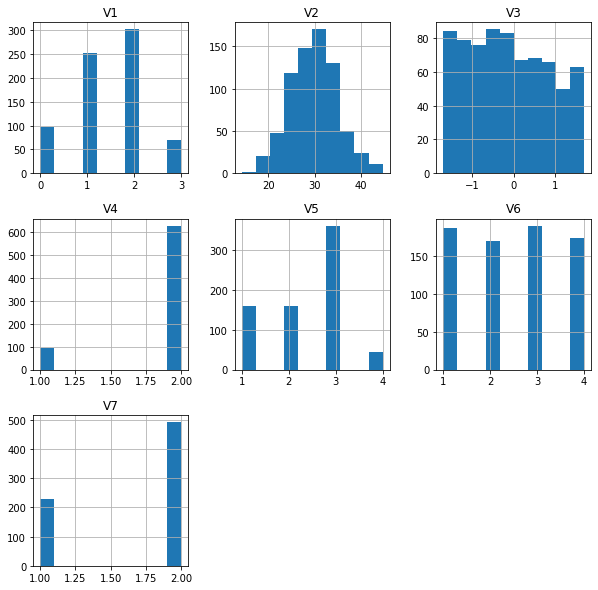

In [11]:
train_data[(train_data['Promotion']=='Yes') & (train_data['purchase']==1)][features].hist(figsize=(10,10)); # Persuadables

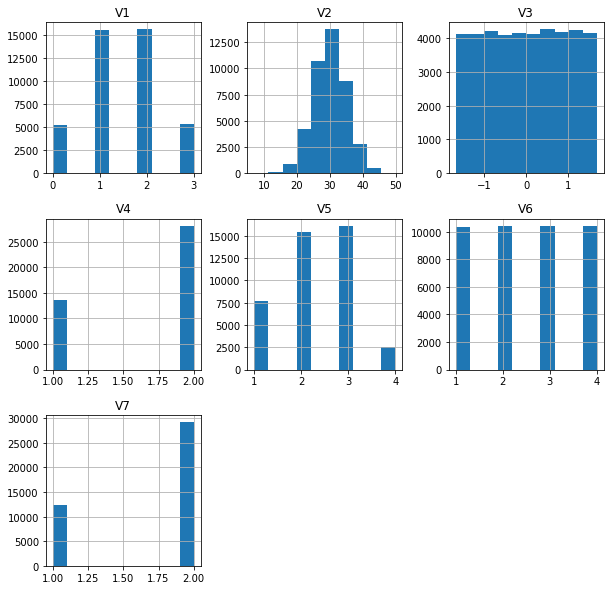

In [12]:
train_data[(train_data['Promotion']=='Yes') & (train_data['purchase']==0)][features].hist(figsize=(10,10)); # Do not disturbs

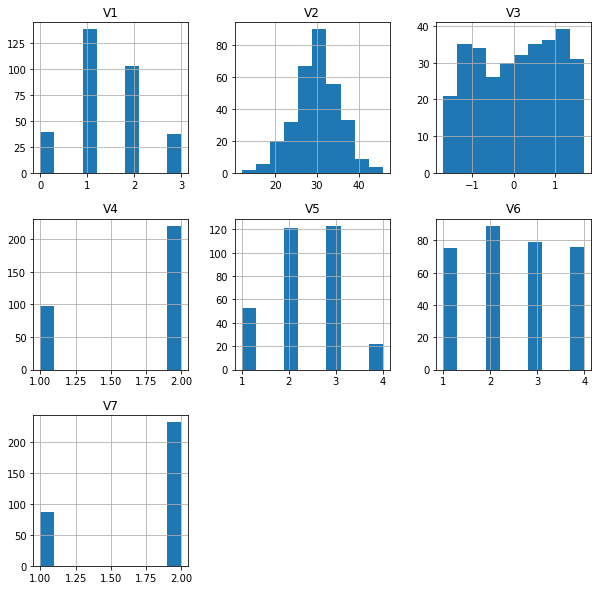

In [13]:
train_data[(train_data['Promotion']=='No') & (train_data['purchase']==1)][features].hist(figsize=(10,10));  # Sure things

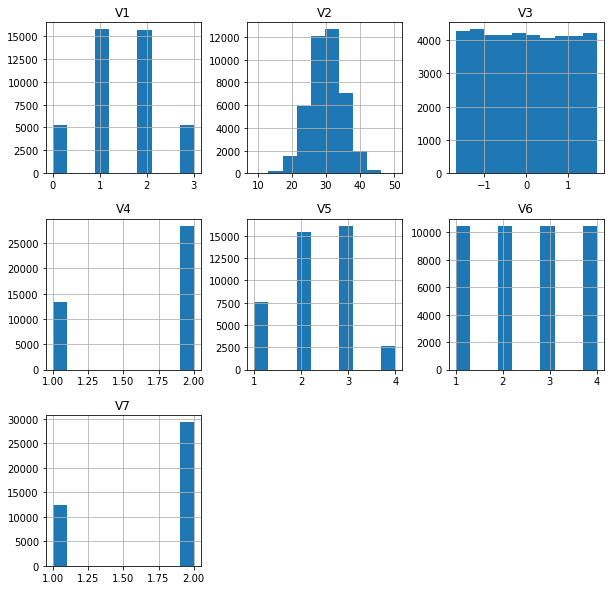

In [14]:
train_data[(train_data['Promotion']=='No') & (train_data['purchase']==0)][features].hist(figsize=(10,10));  # Lost causes

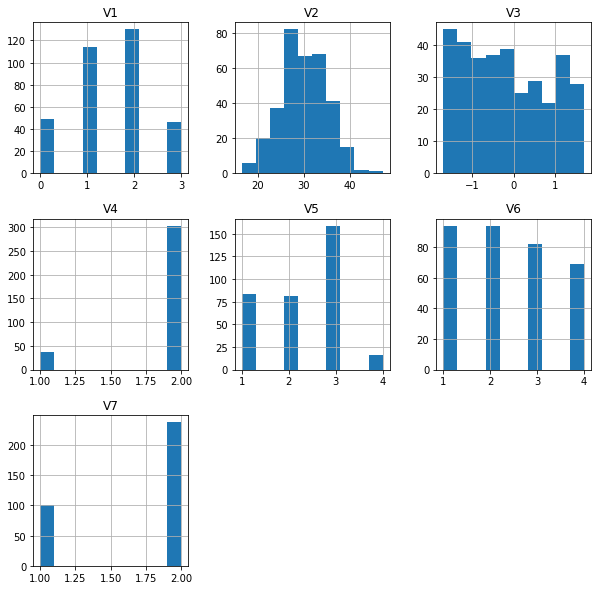

In [15]:
test_data[(test_data['Promotion']=='Yes') & (test_data['purchase']==1)][features].hist(figsize=(10,10));  # Persuadables

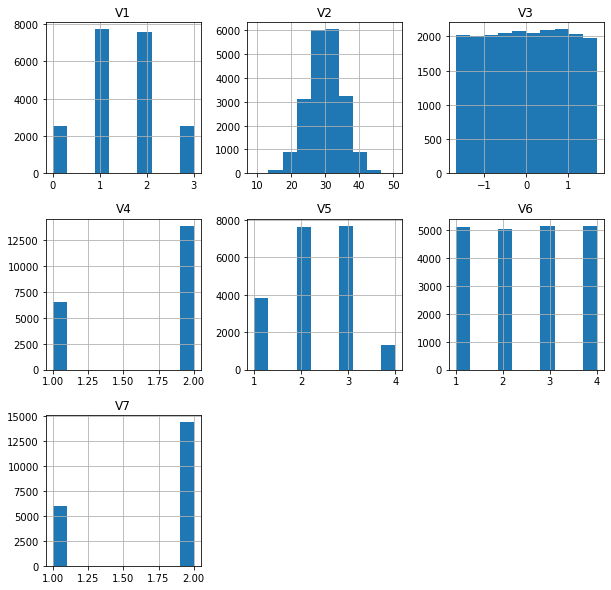

In [16]:
test_data[(test_data['Promotion']=='Yes') & (test_data['purchase']==0)][features].hist(figsize=(10,10));  # Do not disturbs

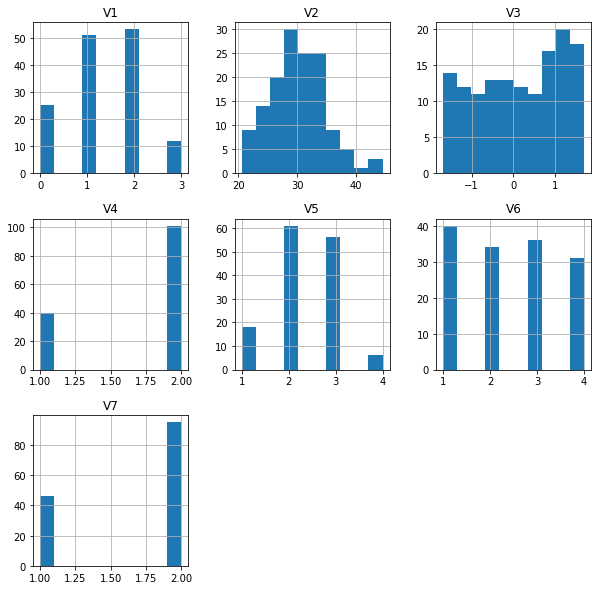

In [17]:
test_data[(test_data['Promotion']=='No') & (test_data['purchase']==1)][features].hist(figsize=(10,10)); # Sure things

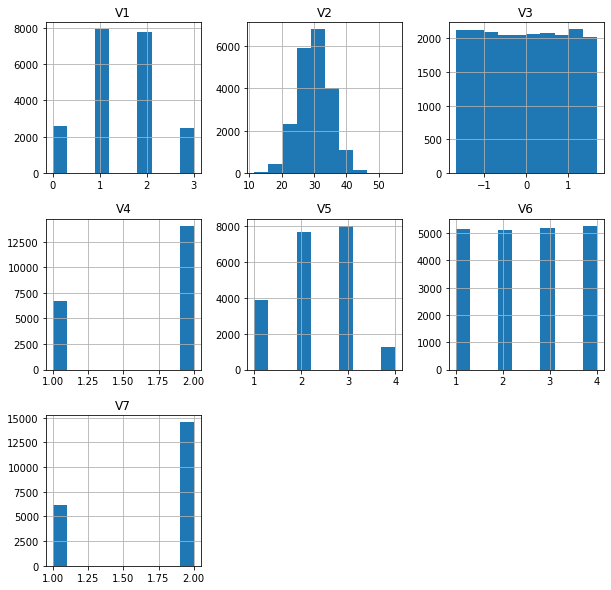

In [18]:
test_data[(test_data['Promotion']=='No') & (test_data['purchase']==0)][features].hist(figsize=(10,10)); # Lost causes

In [19]:
# This is our baseline model, where we send promotions to everyone
def promotion_strategy(df):
    test = df
    
    promotion = []
    
    num_test_points = test.shape[0]
    
    for i in range(num_test_points):
        promotion.append('Yes')
        
    promotion = np.array(promotion)
    
    return promotion

In [20]:
test_results(promotion_strategy)

Your irr with this strategy is 0.0096.

Your nir with this strategy is -1132.20.

Starbuck's baseline model had an irr of 0.0188 and an nir of 189.45 on the test set.



(0.009593158278250108, -1132.1999999999998)

# **Model 1**

In [21]:
# generate labels
# only those who made a purchase after receiving a promotion (persuadables) will be assigned a label of 1
# while the other individuals will be given a label of 0

response = []

for index, row in train_data.iterrows():
    if (row['purchase'] == 1) and (row['Promotion']=='Yes'):
        response.append(1.0)
    else:
        response.append(0.0)
        
train_data['response'] = response

In [22]:
train_data

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7,response
0,1,No,0,2,30.443518,-1.165083,1,1,3,2,0.0
1,3,No,0,3,32.159350,-0.645617,2,3,2,2,0.0
2,4,No,0,2,30.431659,0.133583,1,1,4,2,0.0
3,5,No,0,0,26.588914,-0.212728,2,1,4,2,0.0
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2,0.0
...,...,...,...,...,...,...,...,...,...,...,...
84529,126180,No,0,1,30.084876,1.345672,1,1,3,1,0.0
84530,126181,Yes,0,3,33.501485,-0.299306,1,1,4,1,0.0
84531,126182,No,0,1,31.492019,1.085939,2,3,2,2,0.0
84532,126183,No,0,1,37.766106,0.999361,2,2,1,2,0.0


In [23]:
# split data into train and valid
train, valid = sk.model_selection.train_test_split(train_data, test_size=0.2, random_state=42)

In [24]:
# generate features and labels
Y_train = train['response']
X_train = train[features]

Y_valid = valid['response']
X_valid = valid[features]

In [25]:
Y_train.value_counts()

0.0    67047
1.0      580
Name: response, dtype: int64

In [26]:
Y_valid.value_counts()

0.0    16766
1.0      141
Name: response, dtype: int64

In [27]:
# Up sample only the train dataset with SMOTE
sm = SMOTE(random_state=42, ratio = 1.0)
X_train_upsamp, Y_train_upsamp = sm.fit_sample(X_train, Y_train)
    
X_train_upsamp = pd.DataFrame(X_train_upsamp, columns=features)

Y_train_upsamp = pd.Series(Y_train_upsamp)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [28]:
Y_train_upsamp.value_counts()

1.0    67047
0.0    67047
dtype: int64

In [29]:
# Train an xgboost model
eval_set = [(X_train_upsamp, Y_train_upsamp), (X_valid, Y_valid)]
model = xgb.XGBClassifier(learning_rate = 0.1,\
                          max_depth = 7,\
                          min_child_weight = 5,\
                          objective = 'binary:logistic',\
                          seed = 42,\
                          gamma = 0.1,\
                          silent = True)
model.fit(X_train_upsamp, Y_train_upsamp, eval_set=eval_set,\
          eval_metric="auc", verbose=True, early_stopping_rounds=30)

[0]	validation_0-auc:0.891992	validation_1-auc:0.645481
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.898054	validation_1-auc:0.653202
[2]	validation_0-auc:0.906917	validation_1-auc:0.65697
[3]	validation_0-auc:0.915775	validation_1-auc:0.658408
[4]	validation_0-auc:0.934996	validation_1-auc:0.655914
[5]	validation_0-auc:0.935649	validation_1-auc:0.651876
[6]	validation_0-auc:0.935016	validation_1-auc:0.654039
[7]	validation_0-auc:0.943776	validation_1-auc:0.655699
[8]	validation_0-auc:0.944752	validation_1-auc:0.650929
[9]	validation_0-auc:0.950239	validation_1-auc:0.648446
[10]	validation_0-auc:0.950787	validation_1-auc:0.648789
[11]	validation_0-auc:0.957777	validation_1-auc:0.648527
[12]	validation_0-auc:0.959635	validation_1-auc:0.645952
[13]	validation_0-auc:0.961191	validation_1-auc:0.644991
[14]	validation_0-auc:0.963264	validation_1-auc:0.644359

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=5, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=True, subsample=1, verbosity=1)

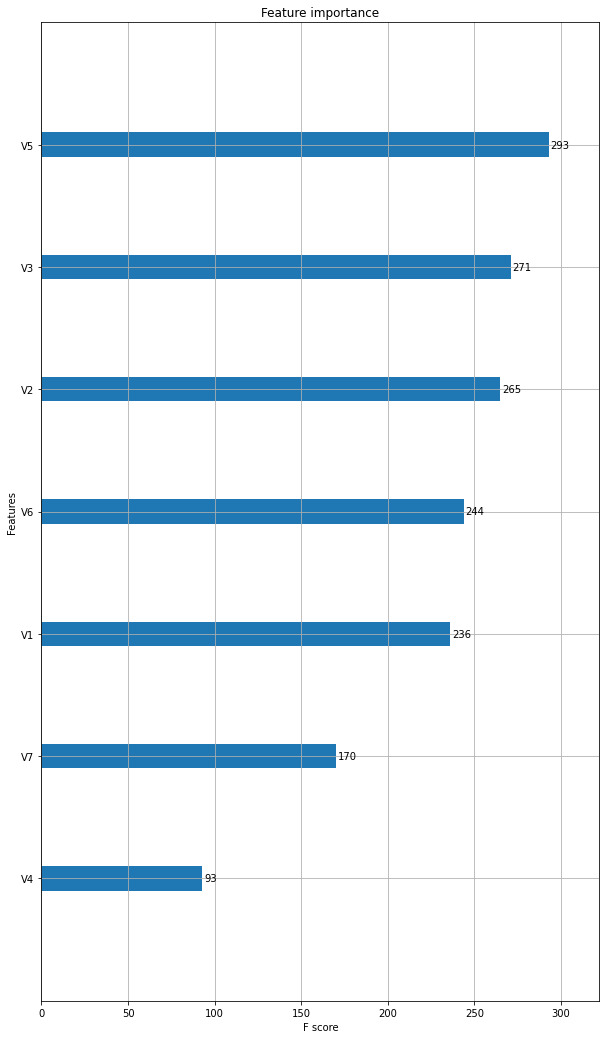

In [30]:
# Check which features are important

from xgboost import plot_importance
from matplotlib import pyplot

fig, ax = pyplot.subplots(figsize=(10, 18));
xgb.plot_importance(model, ax=ax);

In [31]:
# Confusion marix for the validation set
valid_pred = model.predict(X_valid)
cm = sk.metrics.confusion_matrix
cm(Y_valid, valid_pred)

array([[12684,  4082],
       [   83,    58]])

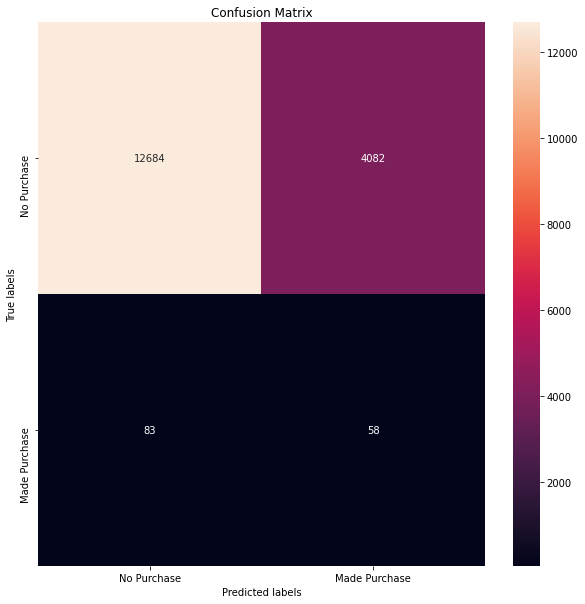

In [32]:
# Confusion marix for the validation set
valid_pred = model.predict(X_valid, ntree_limit=model.best_ntree_limit)
cm = sk.metrics.confusion_matrix(Y_valid, valid_pred)

fig, ax= plt.subplots(figsize=(10,10))
sb.heatmap(cm, annot=True, fmt='g', ax = ax);

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No Purchase', 'Made Purchase']); 
ax.yaxis.set_ticklabels(['No Purchase', 'Made Purchase']);

In [33]:
def promotion_strategy(df):
    test = df
    
    preds = model.predict(test, ntree_limit=model.best_ntree_limit)

    promotion = []
    for pred in preds:
        if pred == 1:
            promotion.append('Yes')
        else:
            promotion.append('No')
    promotion = np.array(promotion)
    return promotion

In [34]:
valid_results(promotion_strategy, valid)  # Calculate IRR and NIR for validation set

Your irr with this strategy is 0.0193.

Your nir with this strategy is 94.70.
Starbuck's baseline model had an irr of 0.0188 and an nir of 189.45 on the test set.


(0.01925125750605293, 94.69999999999999)

In [35]:
test_results(promotion_strategy)  # Calculate IRR and NIR for test set

Your irr with this strategy is 0.0219.

Your nir with this strategy is 332.70.

Starbuck's baseline model had an irr of 0.0188 and an nir of 189.45 on the test set.



(0.02185148545762388, 332.70000000000005)

# **Model 2**

In [36]:
train_data = pd.read_csv('training.csv')
test_data = pd.read_csv('Test.csv')

In [37]:
target = []
for index, row in train_data.iterrows():
    if (row['Promotion'] == "Yes") & (row['purchase'] == 1):
        # TR group (Treatment and Response group) --> Persuadables
        target.append(0)
    elif (row['Promotion'] == "No") & (row['purchase'] == 1):
        # CR group (Control and Response group) --> The sure shots
        target.append(1)
    elif (row['Promotion'] == "Yes") & (row['purchase'] == 0):
        # TN group (Treatment and No response group) --> The Do Not Disturbs
        target.append(2)
    else: #CN group (Control and No response group) --> The lost causes
        target.append(3)

train_data['target'] = target
train_data

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7,target
0,1,No,0,2,30.443518,-1.165083,1,1,3,2,3
1,3,No,0,3,32.159350,-0.645617,2,3,2,2,3
2,4,No,0,2,30.431659,0.133583,1,1,4,2,3
3,5,No,0,0,26.588914,-0.212728,2,1,4,2,3
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...
84529,126180,No,0,1,30.084876,1.345672,1,1,3,1,3
84530,126181,Yes,0,3,33.501485,-0.299306,1,1,4,1,2
84531,126182,No,0,1,31.492019,1.085939,2,3,2,2,3
84532,126183,No,0,1,37.766106,0.999361,2,2,1,2,3


In [38]:
train_data.target.value_counts()

3    41851
2    41643
0      721
1      319
Name: target, dtype: int64

In [39]:
train, valid = sk.model_selection.train_test_split(train_data, test_size=0.2,random_state=42)

features = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']

Y_train = train['target']
X_train = train[features]

Y_valid = valid['target']
X_valid = valid[features]

In [40]:
Y_train.value_counts()

3    33444
2    33351
0      580
1      252
Name: target, dtype: int64

In [41]:
Y_valid.value_counts()

3    8407
2    8292
0     141
1      67
Name: target, dtype: int64

In [42]:
# up sample with SMOTE
sm = SMOTE({0:33444, 1:33444, 2:33444, 3:33444}, random_state=42)
X_train_upsamp, Y_train_upsamp = sm.fit_sample(X_train, Y_train)
    
X_train_upsamp = pd.DataFrame(X_train_upsamp, columns=features)

Y_train_upsamp = pd.Series(Y_train_upsamp)
Y_train_upsamp.value_counts()

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


3    33444
2    33444
1    33444
0    33444
dtype: int64

In [43]:
eval_set = [(X_train_upsamp, Y_train_upsamp), (X_valid, Y_valid)]
model = xgb.XGBClassifier()
model.fit(X_train_upsamp, Y_train_upsamp, eval_set=eval_set,\
                    eval_metric="mlogloss", verbose=True, early_stopping_rounds=30)

[0]	validation_0-mlogloss:1.36693	validation_1-mlogloss:1.37261
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 30 rounds.
[1]	validation_0-mlogloss:1.35115	validation_1-mlogloss:1.36036
[2]	validation_0-mlogloss:1.33496	validation_1-mlogloss:1.34914
[3]	validation_0-mlogloss:1.31982	validation_1-mlogloss:1.33765
[4]	validation_0-mlogloss:1.30734	validation_1-mlogloss:1.32828
[5]	validation_0-mlogloss:1.29698	validation_1-mlogloss:1.32051
[6]	validation_0-mlogloss:1.28487	validation_1-mlogloss:1.31227
[7]	validation_0-mlogloss:1.2728	validation_1-mlogloss:1.3037
[8]	validation_0-mlogloss:1.26456	validation_1-mlogloss:1.29721
[9]	validation_0-mlogloss:1.25455	validation_1-mlogloss:1.29001
[10]	validation_0-mlogloss:1.24557	validation_1-mlogloss:1.28319
[11]	validation_0-mlogloss:1.23776	validation_1-mlogloss:1.27772
[12]	validation_0-mlogloss:1.23118	validation_1-mlogloss:1.27207


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

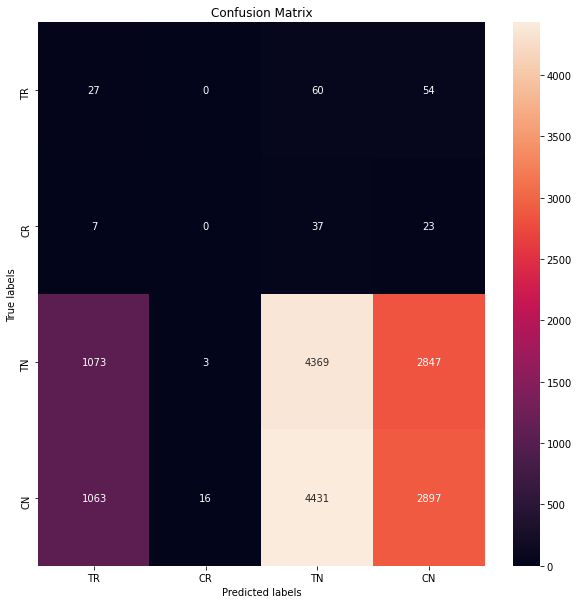

In [44]:
# confusion marix for the validation set
# Note:
# TR: treatment and respond group (received promotion and made purchase)
# CR: control and respond group (did not receive promotion but made purchase)
# TN: treatment and no respond group (received promotion but did not made purchase)
# CR: control and no respond group (did not receive promotion and made no purchase)
valid_pred = model.predict(X_valid)
cm = sk.metrics.confusion_matrix(Y_valid, valid_pred)

fig, ax= plt.subplots(figsize=(10,10))
sb.heatmap(cm, annot=True, fmt='g', ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['TR', 'CR', 'TN', 'CN']); 
ax.yaxis.set_ticklabels(['TR', 'CR', 'TN', 'CN']);

In [45]:
def promotion_strategy(df):
    test = df
    
    pred = model.predict(test)
    
    promotion = []
    
    for pred in pred:
        if pred == 0:
            promotion.append('Yes')
        else:
            promotion.append('No')
    
    promotion = np.array(promotion)
    
    return promotion

In [46]:
# find out IRR and NIR on our validation set
valid_results(promotion_strategy, valid)

Your irr with this strategy is 0.0180.

Your nir with this strategy is 35.00.
Starbuck's baseline model had an irr of 0.0188 and an nir of 189.45 on the test set.


(0.018003398470688187, 35.0)

In [47]:
test_results(promotion_strategy)

Your irr with this strategy is 0.0236.

Your nir with this strategy is 214.95.

Starbuck's baseline model had an irr of 0.0188 and an nir of 189.45 on the test set.



(0.023570064047996834, 214.95)